In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
import qubit_templates
from qubit_templates import *
from functions import *

# Read configuration file

In [3]:
feedline_resonator_gap = 13 
n_gridline = 20
JJtype = "mh" # mh or dl (manhattan or dolan)
Bandage = False
DCLine = True # Add DC line next to squids
Entangle = True # Connect two transmons
SimulationDesign = False # Make inverted design for HFSS simulation (This takes a long time...)

outname = "TcSampleDesign"

config = load_config( f"config/common_Tc.yaml" )
# グローバル変数として定義
globals().update(config)
qubit_templates.__dict__.update(config)

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

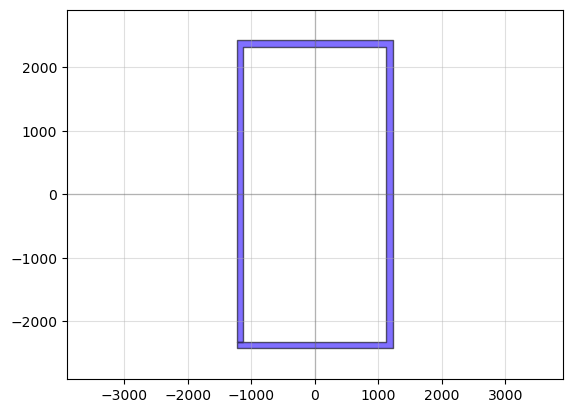

In [5]:
chipdesign = Device('chipdesign')

FM=Device('frame')
rectangle = pg.rectangle((Frame_size_width, Frame_size_height), Frame_layer)
FM.add_ref( pg.invert(rectangle, border = Frame_width, precision = 1e-6, layer = Frame_layer) )
FM.center = (0, 0)

chipdesign.add_ref(FM)
# Quickplot the imported design
qp(chipdesign)

# Launch pad

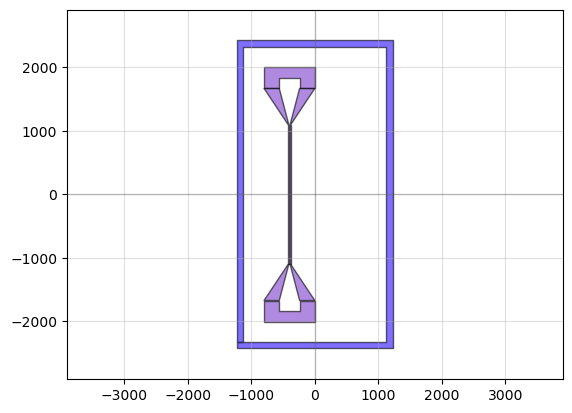

In [6]:
FL = device_FeedLine_Tc()
FL.movex(-400)
chipdesign.add_ref(FL)
qp(chipdesign)


# Corner points

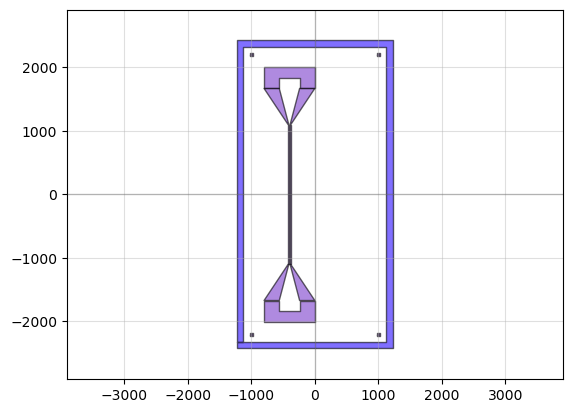

In [7]:
CP = device_CornerPoints()
chipdesign.add_ref(CP)
qp(chipdesign)

# Resonator

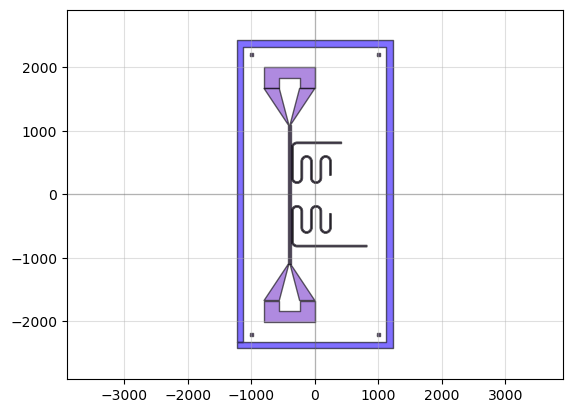

In [8]:
R1_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 700, transmon = False, mirror = True)
R1_tmp.rotate(-90)
R1_tmp.xmin = FL.x + 0.5*LaunchPad_trace_width + LaunchPad_trace_gap_width + feedline_resonator_gap
R1_tmp.y = 500
R1 = pg.copy_layer(R1_tmp, 4, 4)
chipdesign.add_ref(R1)

R2_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1100, transmon = False)
R2_tmp.rotate(90)
R2_tmp.y = -500
R2_tmp.xmin = FL.x + 0.5*LaunchPad_trace_width + LaunchPad_trace_gap_width + feedline_resonator_gap
R2 = pg.copy_layer(R2_tmp, 4, 4)
chipdesign.add_ref(R2)

chipdesign.write_gds('output/test.gds')
qp(chipdesign)

In [9]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(chipdesign) 

    return chip

# Place chip designs

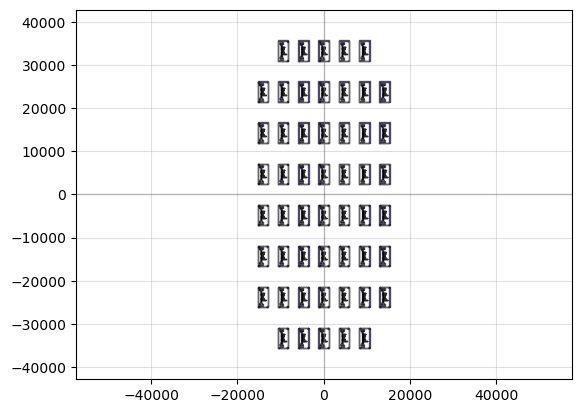

In [10]:

D = pg.gridsweep(
    function = custom_chip,
    param_x = {'width' :  [0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165]},
    param_y = {'height' : [10, 10, 10, 10, 10, 10, 10, 10]},
    spacing = (Frame_size_width, Frame_size_height),
    label_layer = None
    )
D.center = (0,0)
# D = D.movex(-6*4800).movey(-7*4800)
# pprint.pprint(D.references)

## Remove corners
xmin = min([ref.center[0] for ref in D.references])
xmax = max([ref.center[0] for ref in D.references])
ymin = min([ref.center[1] for ref in D.references])
ymax = max([ref.center[1] for ref in D.references])
for ref in D.references:
    # print( ref.center )
    # print( ref.size )
    if (ref.center == (xmin, ymin)).all() or (ref.center == (xmax, ymin)).all() or (ref.center == (xmin, ymax)).all() or (ref.center == (xmax, ymax)).all():
        D.remove(ref)
wafer.add_ref(D)
qp(D)


# Add grid lines

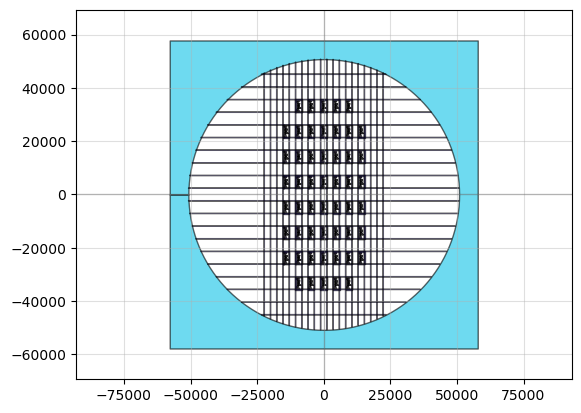

In [11]:
grid = device_Grid(inch = 4, n_gridline = n_gridline)
wafer.add_ref( grid )

qp(wafer)


In [12]:
wafer.write_gds('output/' + outname)

'output/TcSampleDesign.gds'